In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten
from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras.utils.np_utils import to_categorical

from sklearn.metrics import accuracy_score

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
img_size = 28

In [3]:
X = train.iloc[:,1:] 
y = train.iloc[:,0]
X.shape

(42000, 784)

In [4]:
X.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
max(X.max(axis=0))

255

Normalizing from 0-255 to 0-1

In [6]:
X = X.divide(255)
max(X.max(axis=0))

1.0

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Trying naive Bayes

In [8]:
bayes_clf = BernoulliNB().fit(X_train, y_train)
bayes_pred = bayes_clf.predict(X_test)
print(accuracy_score(y_test, bayes_pred))

0.834047619047619


From printing head of data, it is obvious that there are lots of zeros and too many features

0.41563492063492063


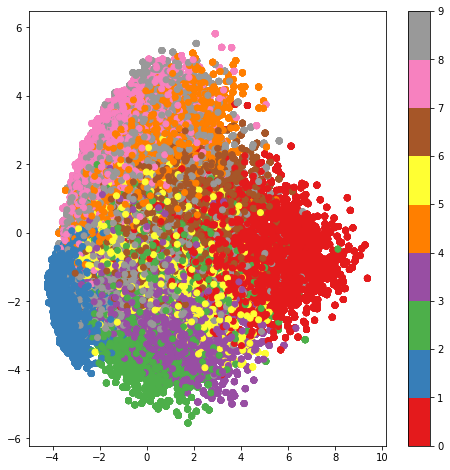

In [9]:
fig = plt.figure(figsize=(8,8))
pca = PCA(n_components=2)
pca_X = pca.fit_transform(X)

for num in range(10):
    plt.scatter(pca_X[:,0], pca_X[:,1], c=y, cmap='Set1')
plt.colorbar()

X_train, X_test, y_train, y_test = train_test_split(pca_X, y, test_size=0.3)

clf = KNeighborsClassifier()
clf.fit(X_train, y_train)
pca_pred = clf.predict(X_test)
print(accuracy_score(y_test, pca_pred))

It looks not that bad, so I tried different amounts of components. I think t-sne would have worked better,
but it took too long to fit

5
10
20
30
40
50
60
70
100
0.9732539682539683


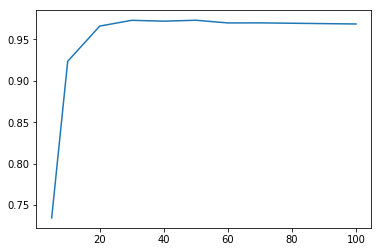

In [10]:
max_i = -1;
max_score = 0
scores = []
indices = [5, 10, 20, 30, 40, 50, 60, 70, 100]
for i in indices:
    print(i)
    pca = PCA(n_components=i)
    pca_X = pca.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(pca_X, y, test_size=0.3)

    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)
    pca_pred = clf.predict(X_test)
    score = accuracy_score(y_test, pca_pred)
    scores.append(score)
    
    if score > max_score:
        max_score = score
        max_i = i

plt.plot(indices, scores)
print(max_score)

The accuracy gets stuck at around 35-40 and doesn't go up much,
so I tried neural networks as suggested in the tutorial

In [11]:
X_matrix = X.values.reshape(len(X), img_size, img_size, 1)
model = Sequential()

model.add(Conv2D(20, input_shape=(img_size, img_size, 1), kernel_size=3, activation='relu'))
model.add(Conv2D(20, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_matrix, y, test_size=0.3)
y_train = to_categorical(y_train)
model.fit(X_train, y_train,
          batch_size=300,
          epochs=4,
          validation_split = 0.3)

keras_pred = model.predict(X_test)

Train on 20580 samples, validate on 8820 samples
Epoch 1/4
20580/20580 [==============================] - 27s 1ms/step - loss: 0.4657 - acc: 0.8647 - val_loss: 0.2017 - val_acc: 0.9413
Epoch 2/4
20580/20580 [==============================] - 29s 1ms/step - loss: 0.1353 - acc: 0.9621 - val_loss: 0.1078 - val_acc: 0.9685
Epoch 3/4
20580/20580 [==============================] - 30s 1ms/step - loss: 0.0736 - acc: 0.9793 - val_loss: 0.1009 - val_acc: 0.9676
Epoch 4/4
20580/20580 [==============================] - 29s 1ms/step - loss: 0.0494 - acc: 0.9844 - val_loss: 0.0884 - val_acc: 0.9729


4
0
0
4
0
0
0
2
1
0.9745238095238096


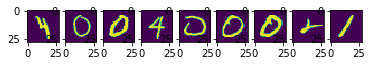

In [13]:
y_pred_keras = np.argmax(keras_pred, axis=1)

for i in range(9):
    print(y_pred_keras[i])
    plt.subplot(1, 9, i+1)
    plt.imshow(X_test[i].reshape(img_size, img_size))

print(accuracy_score(y_test, y_pred_keras))

It worked out better than pca + neighbours, so I trained on all data and created submission

In [14]:
model.fit(X_matrix, to_categorical(y),
          batch_size=300,
          epochs=4,
          validation_split = 0.3)
test = test.divide(255)
testing_data = test.values.reshape(len(test), img_size, img_size, 1)

Train on 29399 samples, validate on 12601 samples
Epoch 1/4
29399/29399 [==============================] - 42s 1ms/step - loss: 0.0533 - acc: 0.9838 - val_loss: 0.0478 - val_acc: 0.9854
Epoch 2/4
29399/29399 [==============================] - 41s 1ms/step - loss: 0.0329 - acc: 0.9901 - val_loss: 0.0491 - val_acc: 0.9849
Epoch 3/4
29399/29399 [==============================] - 42s 1ms/step - loss: 0.0214 - acc: 0.9936 - val_loss: 0.0494 - val_acc: 0.9853
Epoch 4/4
29399/29399 [==============================] - 38s 1ms/step - loss: 0.0156 - acc: 0.9960 - val_loss: 0.0537 - val_acc: 0.9848


In [15]:
prediction = np.argmax(model.predict(testing_data), axis=1)

In [16]:
f = open('result.csv','w')
f.write('ImageId,Label\n')
for i, pred in enumerate(prediction):
    f.write(str(i+1) + ',' + str(pred))
    f.write('\n')
print(len(prediction))

28000
